In [2]:
# from numpy.linalg import inv
# from scipy import misc

# import numpy as np
# import matplotlib.pyplot as plt
# import math
# import pandas as pd
# import geopandas as gpd

# from shapely.geometry import Point

# import sklearn.preprocessing

# from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit, RepeatedStratifiedKFold
# from sklearn.metrics import precision_score, recall_score, roc_auc_score
# from customGP import GaussianProcess


#from dataloader import get_train_test


In [27]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import Bounds
from pyDOE import lhs
import matplotlib.pyplot as plt
import math
import pandas as pd

###########
# import our libraries
from blue_conduit_spatial.utilities import build_datasets
from blue_conduit_spatial.evaluation import *

In [17]:
# this is kinda slow

Xtrain, Xtest, Ytrain, Ytest = build_datasets('../data/flint_sl_materials')

n_train = 100
n_train_ensemble = 100
n_test_small = 200
n_test_small_ensemble = 100

train_sample_idx = [np.random.choice(np.arange(Xtrain.shape[0]),size=n_train) for i in range(n_train_ensemble)]
features = ['Latitude', 'Longitude']

Xtrains = [Xtrain[features].values[tsi,:] for tsi in train_sample_idx]
Xtest = Xtest[features].values
Ytrains = [Ytrain[['dangerous']].values[tsi].astype(int).flatten() for tsi in train_sample_idx]
Ytest = Ytest[['dangerous']].values.astype(int).flatten()

test_small_idx = [np.random.choice(np.arange(Xtest.shape[0]), size=n_test_small) for i in range(n_test_small_ensemble)]
Xtests_small, Ytests_small = [Xtest[tsi,:] for tsi in test_small_idx], [Ytest[tsi] for tsi in test_small_idx]

Xtrains[0].shape, Ytrains[0].shape, Xtest.shape, Ytest.shape, Xtests_small[0].shape, Ytests_small[0].shape

((100, 2), (100,), (6778, 2), (6778,), (200, 2), (200,))

In [15]:
class GaussianProcess:
    """A Gaussian Process class for creating and exploiting  
    a Gaussian Process model"""

    
    def __init__(self, n_restarts, optimizer):
        """Initialize a Gaussian Process model
        
        Input
        ------
        n_restarts: number of restarts of the local optimizer
        optimizer: algorithm of local optimization"""
        
        self.n_restarts = n_restarts
        self.optimizer = optimizer


    def Corr(self, X1, X2, theta):
        """Construct the correlation matrix between X1 and X2
        
        Input
        -----
        X1, X2: 2D arrays, (n_samples, n_features)
        theta: array, correlation legnths for different dimensions
        
        Output
        ------
        K: the correlation matrix
        """
        K = np.zeros((X1.shape[0],X2.shape[0]))
        for i in range(X1.shape[0]):
            K[i,:] = np.exp(-np.sum(theta*(X1[i,:]-X2)**2, axis=1))
            
        return K


    def Neglikelihood(self, theta):
        """Negative likelihood function
        
        Input
        -----
        theta: array, logarithm of the correlation legnths for different dimensions
        
        Output
        ------
        LnLike: likelihood value"""
        
        theta = 10**theta    # Correlation length
        n = self.X.shape[0]  # Number of training instances
        one = np.ones((n,1))      # Vector of ones
        
        # Construct correlation matrix
        K = self.Corr(self.X, self.X, theta) + np.eye(n)*1e-10
        inv_K = np.linalg.inv(K)   # Inverse of correlation matrix
        
        # Mean estimation
        mu = (one.T @ inv_K @ self.y)/ (one.T @ inv_K @ one)
        
        # Variance estimation
        SigmaSqr = (self.y-mu*one).T @ inv_K @ (self.y-mu*one) / n
        
        # Compute log-likelihood
        DetK = np.linalg.det(K)
        
        # !!!
        # adding 1e-12 to each log term here 
        LnLike = -(n/2)*np.log(SigmaSqr + 1e-12) - 0.5*np.log(DetK + 1e-12)
        
        # Update attributes
        self.K, self.inv_K , self.mu, self.SigmaSqr = K, inv_K, mu, SigmaSqr
        
        return -LnLike.flatten()


    def fit(self, X, y):
        """GP model training
        
        Input
        -----
        X: 2D array of shape (n_samples, n_features)
        y: 2D array of shape (n_samples, 1)
        """
        
        self.X, self.y = X, y
        lb, ub = -3, 2
        
        # Generate random starting points (Latin Hypercube)
        lhd = lhs(self.X.shape[1], samples=self.n_restarts)
        
        # Scale random samples to the given bounds 
        initial_points = (ub-lb)*lhd + lb
        
        # Create A Bounds instance for optimization
        bnds = Bounds(lb*np.ones(X.shape[1]),ub*np.ones(X.shape[1]))
        
        # Run local optimizer on all points
        opt_para = np.zeros((self.n_restarts, self.X.shape[1]))
        opt_func = np.zeros((self.n_restarts, 1))
        for i in range(self.n_restarts):
            res = minimize(self.Neglikelihood, initial_points[i,:], method=self.optimizer,
                bounds=bnds)
            opt_para[i,:] = res.x
            opt_func[i,:] = res.fun
        
        # Locate the optimum results
        self.theta = opt_para[np.argmin(opt_func)]
        
        # Update attributes
        self.NegLnlike = self.Neglikelihood(self.theta)


    def predict(self, X_test):
        """GP model predicting
        
        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)
        
        Output
        ------
        f: GP predictions
        SSqr: Prediction variances"""
        
        n = self.X.shape[0]
        one = np.ones((n,1))
        
        # Construct correlation matrix between test and train data
        k = self.Corr(self.X, X_test, 10**self.theta)
        
        # Mean prediction
        f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)
        
        # Variance prediction
        SSqr = self.SigmaSqr*(1 - np.diag(k.T @ self.inv_K @ k))
        
        return f.flatten(), SSqr.flatten()

In [5]:
# def get_custom_gp(X, y):
#     GP = GaussianProcess(n_restarts=10, optimizer='L-BFGS-B')
#     GP.fit(X, y.reshape(-1,1))
#     return GP

In [3]:
# def plot_model(fig, ax, model, X, y, title):
    
#     # setup mesh
#     x1v, x2v = np.meshgrid(np.linspace(LAT_MIN, LAT_MAX,100), np.linspace(LON_MIN, LON_MAX,100))
#     xgrid = np.c_[x1v.ravel(), x2v.ravel()]

#     # predict on the mesh
#     ygrid_prob = model.predict_proba(xgrid)[:,1].reshape(x1v.shape)    
#     colormesh = ax.pcolormesh(x1v, x2v, ygrid_prob,alpha = 0.8, shading='auto')
#     fig.colorbar(colormesh, ax=ax)
    
#     # plot data
#     dangerous_indices = [i for i in range(len(y)) if y[i]==1]
#     safe_indices = [i for i in range(len(y)) if y[i]==0]
#     ax.scatter(X[dangerous_indices,0], X[dangerous_indices,1], marker= 'x', s=200)
#     ax.scatter(X[safe_indices,0], X[safe_indices,1], marker= 'o', s=200, alpha=.1)
    
#     # decision boundary of 0.5
#     cs = ax.contour(x1v, x2v, ygrid_prob, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)
#     ax.clabel(cs, fontsize=20)

#     ax.set_xlabel('Latitude')
#     ax.set_ylabel('Longitude')
#     ax.set_xlim(LAT_MIN, LAT_MAX)
#     ax.set_ylim(LON_MIN, LON_MAX)
#     ax.set_title(title)

In [19]:
x_train, y_train = Xtrains[0], Ytrains[0]
y_train

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1])

In [20]:
GP = GaussianProcess(n_restarts=10, optimizer='L-BFGS-B')

GP.fit(x_train, y_train.reshape(-1,1))

In [35]:
mean, variance = GP.predict(Xtest)
mean.shape

(6778,)

In [40]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
sigmoid(mean)

<ipython-input-40-5dff665bedd0>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


array([0.56513301, 0.57284937, 0.5476261 , ..., 0.58876953, 0.61527736,
       0.53559698])

(6778,) (6778,)


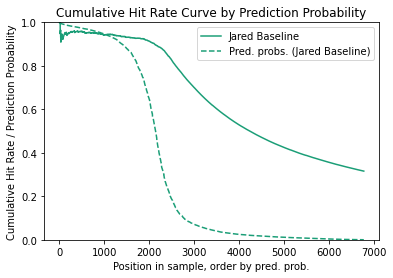

In [28]:
jared_train_pred = pd.read_csv('../data/jared_train_yhat.csv').values
jared_test_pred = pd.read_csv('../data/jared_test_yhat.csv').values
jared_small_train_pred = pd.read_csv('../data/jared_train_yhat_small_train.csv').values
jared_small_test_pred = pd.read_csv('../data/jared_test_yhat_small_train.csv').values
print(Ytest.shape, jared_test_pred[:,1].shape)
plot_hit_rate_curve(Ytest, jared_test_pred[:,1], labels=['Jared Baseline'])

<ipython-input-40-5dff665bedd0>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


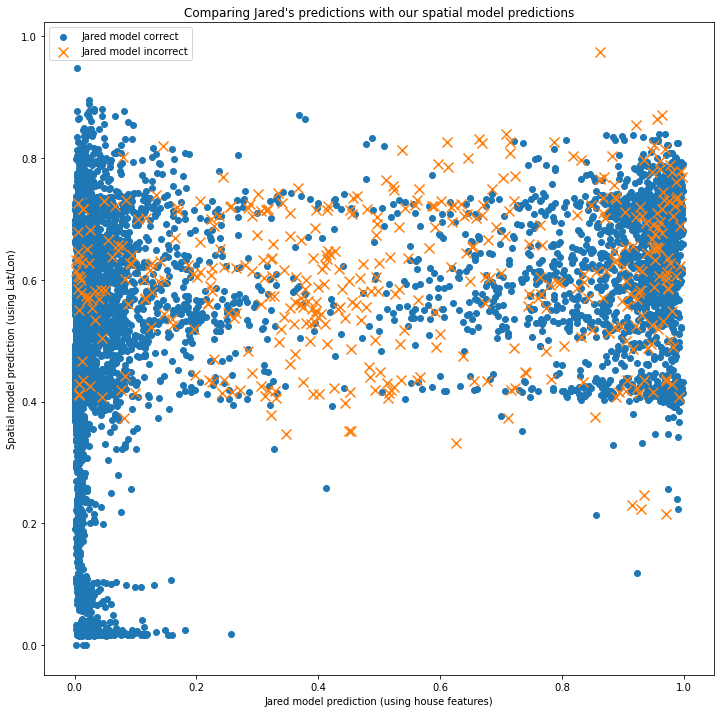

In [41]:
fig, ax = plt.subplots(figsize=(12,12))

spatial_test_pred, _ = GP.predict(Xtest)
spatial_test_pred = sigmoid(spatial_test_pred)
jared_right_indices = np.array([i for i in range(len(Ytest)) if Ytest[i]==np.round(jared_test_pred[:,1][i]).astype(int)])
jared_wrong_indices = np.array([i for i in range(len(Ytest)) if Ytest[i]!=np.round(jared_test_pred[:,1][i]).astype(int)])


ax.scatter(jared_test_pred[jared_right_indices,1], spatial_test_pred[jared_right_indices], marker='o', label='Jared model correct')
ax.scatter(jared_test_pred[jared_wrong_indices,1], spatial_test_pred[jared_wrong_indices], marker='x', s=100, label='Jared model incorrect')
ax.set_xlabel('Jared model prediction (using house features)')
ax.set_ylabel('Spatial model prediction (using Lat/Lon)')
ax.set_title('Comparing Jared\'s predictions with our spatial model predictions')
ax.legend()
plt.show()